<a href="https://colab.research.google.com/github/manegene/Cat-and-Dog-Classifier/blob/main/Copy_of_fcc_cat_dog.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [25]:
try:
  # This command only in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D,Input,BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


In [26]:
# Get project files
!wget https://cdn.freecodecamp.org/project-data/cats-and-dogs/cats_and_dogs.zip

!unzip cats_and_dogs.zip

PATH = 'cats_and_dogs'

train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')
test_dir = os.path.join(PATH, 'test')

# Get number of files in each directory. The train and validation directories
# each have the subdirecories "dogs" and "cats".
total_train = sum([len(files) for r, d, files in os.walk(train_dir)])
total_val = sum([len(files) for r, d, files in os.walk(validation_dir)])
total_test = sum([len(os.listdir(test_dir))])

#add test images to a dataframe since test directory has no sub-directories and flow_from_directory require sub-folders
test_df = pd.DataFrame({'filename': os.listdir(test_dir)})
print(test_df.head())

# Variables for pre-processing and training.
batch_size = 128
epochs = 25
IMG_HEIGHT = 150
IMG_WIDTH = 150


#print("Does test_dir exist?:", os.path.exists(test_dir))
#print("Contents of test_dir:", os.listdir(test_dir) if os.path.exists(test_dir) else "Directory does not exist")
print("Total training images:", total_train)
print("Total validation images:", total_val)
print("Total test images:", total_test)


--2025-03-07 09:55:19--  https://cdn.freecodecamp.org/project-data/cats-and-dogs/cats_and_dogs.zip
Resolving cdn.freecodecamp.org (cdn.freecodecamp.org)... 104.26.2.33, 104.26.3.33, 172.67.70.149, ...
Connecting to cdn.freecodecamp.org (cdn.freecodecamp.org)|104.26.2.33|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 70702765 (67M) [application/zip]
Saving to: ‘cats_and_dogs.zip.2’

cats_and_dogs.zip.2 100%[===================>]  67.43M   254MB/s    in 0.3s    

2025-03-07 09:55:20 (254 MB/s) - ‘cats_and_dogs.zip.2’ saved [70702765/70702765]

Archive:  cats_and_dogs.zip
replace cats_and_dogs/.DS_Store? [y]es, [n]o, [A]ll, [N]one, [r]ename:   filename
0   47.jpg
1   24.jpg
2   22.jpg
3    9.jpg
4   44.jpg
Total training images: 2001
Total validation images: 1001
Total test images: 51


In [27]:
# 3
train_image_generator = ImageDataGenerator(rescale=1./255,
                                           rotation_range=40,  # Randomly rotate images
                                            width_shift_range=0.2,  # Randomly shift width
                                            height_shift_range=0.2,  # Randomly shift height
                                            shear_range=0.2,  # Apply shearing
                                            zoom_range=0.2,  # Apply zoom
                                            horizontal_flip=True,  # Flip images horizontally
                                            fill_mode='nearest')  # Fill in missing pixels)
validation_image_generator = ImageDataGenerator(rescale=1./255)
test_image_generator = ImageDataGenerator(rescale=1./255)


train_data_gen = train_image_generator.flow_from_directory(batch_size=batch_size,
                                                            directory=train_dir,
                                                            target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                            class_mode='binary')

val_data_gen = validation_image_generator.flow_from_directory(batch_size=batch_size,
                                                               directory=validation_dir,
                                                               target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                               class_mode='binary')
#here we use the test dataframe
test_data_gen = test_image_generator.flow_from_dataframe(batch_size=batch_size,
                                                         dataframe=test_df,
                                                         x_col='filename',
                                                         y_col=None,
                                                         directory=test_dir,
                                                         target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                         class_mode=None,
                                                         shuffle=False)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 50 validated image filenames.


/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:920: UserWarning: Found 1 invalid image filename(s) in x_col="filename". These filename(s) will be ignored.
  warnings.warn(


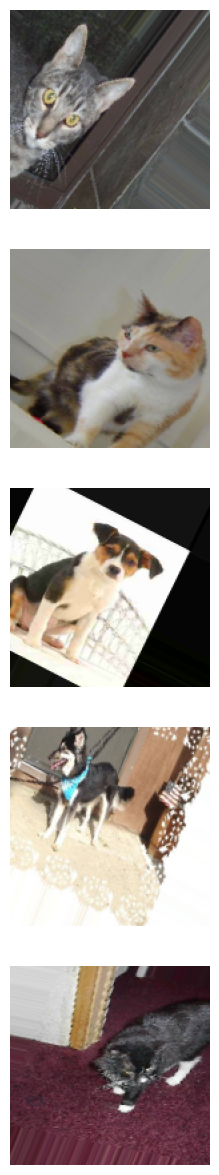

In [28]:
# 4
def plotImages(images_arr, probabilities = False):
    fig, axes = plt.subplots(len(images_arr), 1, figsize=(5,len(images_arr) * 3))
    if probabilities is False:
      for img, ax in zip( images_arr, axes):
          ax.imshow(img)
          ax.axis('off')
    else:
      for img, probability, ax in zip( images_arr, probabilities, axes):
          ax.imshow(img)
          ax.axis('off')
          if probability > 0.5:
              ax.set_title("%.2f" % (probability*100) + "% dog")
          else:
              ax.set_title("%.2f" % ((1-probability)*100) + "% cat")
    plt.show()

sample_training_images, _ = next(train_data_gen)
plotImages(sample_training_images[:5])


In [29]:
# 5
train_image_generator = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

Found 2000 images belonging to 2 classes.


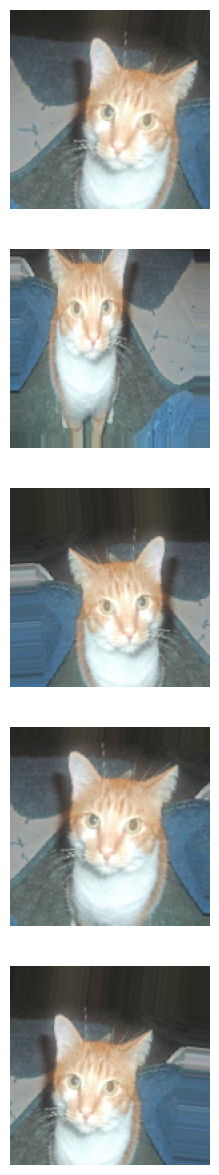

In [30]:
# 6
train_data_gen = train_image_generator.flow_from_directory(batch_size=batch_size,
                                                     directory=train_dir,
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                     class_mode='binary')

augmented_images = [train_data_gen[0][0][0] for i in range(5)]

plotImages(augmented_images)

In [31]:
# 7
model = Sequential([
    Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3)),

    Conv2D(32, (3,3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(2,2),

    Conv2D(64, (3,3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(2,2),

    Conv2D(128, (3,3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(2,2),

    Conv2D(256, (3,3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(2,2),

    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),  # Dropout to prevent overfitting
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')  # Binary classification
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [32]:
# 8
history = model.fit(
    train_data_gen,
    steps_per_epoch=total_train // batch_size,
    epochs=epochs,
    validation_data=val_data_gen,
    validation_steps=total_val // batch_size
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/25
15/15 ━━━━━━━━━━━━━━━━━━━━ 241s 16s/step - accuracy: 0.5175 - loss: 4.5215 - val_accuracy: 0.4944 - val_loss: 0.7652
Epoch 2/25
 1/15 ━━━━━━━━━━━━━━━━━━━━ 3:16 14s/step - accuracy: 0.4609 - loss: 3.5502

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


15/15 ━━━━━━━━━━━━━━━━━━━━ 43s 2s/step - accuracy: 0.4609 - loss: 3.5502 - val_accuracy: 0.4866 - val_loss: 0.7304
Epoch 3/25
15/15 ━━━━━━━━━━━━━━━━━━━━ 226s 15s/step - accuracy: 0.5397 - loss: 2.5287 - val_accuracy: 0.5112 - val_loss: 0.7373
Epoch 4/25
15/15 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step - accuracy: 0.5156 - loss: 2.2088 - val_accuracy: 0.5212 - val_loss: 0.7308
Epoch 5/25
15/15 ━━━━━━━━━━━━━━━━━━━━ 289s 16s/step - accuracy: 0.5667 - loss: 1.8816 - val_accuracy: 0.4911 - val_loss: 0.7394
Epoch 6/25
15/15 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step - accuracy: 0.5625 - loss: 1.5499 - val_accuracy: 0.4944 - val_loss: 0.7256
Epoch 7/25
15/15 ━━━━━━━━━━━━━━━━━━━━ 261s 18s/step - accuracy: 0.5393 - loss: 1.4203 - val_accuracy: 0.5022 - val_loss: 0.7460
Epoch 8/25
15/15 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step - accuracy: 0.5234 - loss: 1.2987 - val_accuracy: 0.5011 - val_loss: 0.7266
Epoch 9/25
15/15 ━━━━━━━━━━━━━━━━━━━━ 261s 18s/step - accuracy: 0.5555 - loss: 1.0838 - val_accuracy: 0.5424 - val_loss: 0.

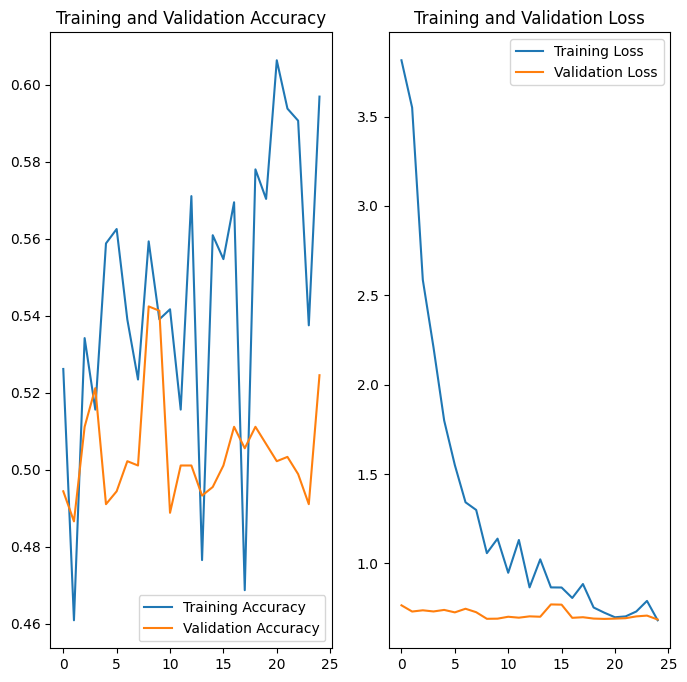

In [33]:
# 9
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [34]:
# 10
test_data_gen.reset()
probabilities = model.predict(test_data_gen).flatten()

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


In [35]:
# 11
answers =  [1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0,
            1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0,
            1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1,
            1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1,
            0, 0, 0, 0, 0, 0]

correct = 0

for probability, answer in zip(probabilities, answers):
  if round(probability) == answer:
    correct +=1

percentage_identified = (correct / len(answers)) * 100

passed_challenge = percentage_identified >= 63

print(f"Your model correctly identified {round(percentage_identified, 2)}% of the images of cats and dogs.")

if passed_challenge:
  print("You passed the challenge!")
else:
  print("You haven't passed yet. Your model should identify at least 63% of the images. Keep trying. You will get it!")

Your model correctly identified 50.0% of the images of cats and dogs.
You haven't passed yet. Your model should identify at least 63% of the images. Keep trying. You will get it!
